In [1]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Definiciones

In [2]:
meses = ['202112','202201','202202','202203','202204']   # Meses a analizar
seccion = 'politica'   # Sección para filtrar, si queda en blanco se usan todas las noticias
objeto = 3   # 1 solo titulos 2 solo cuerpo 3 ambos (default)

### Descarga y lectura del dataset

In [3]:
# Leemos todos los csvs mensuales
# Integramos todo en un único DataFrame

files = {}

for m in meses:
    url = 'https://github.com/fermasia/news-base/blob/main/files/' + m + '.csv.gz?raw=true'
    files[m] = pd.read_csv(url, compression='gzip')
    
df = pd.concat(files.values(), ignore_index=True)

#del files

In [4]:
for m in meses:
    print(m,len(files[m].link))

202112 25090
202201 30363
202202 23109
202203 18172
202204 13931


### Vamos a construir un campo que tenga el dato de AAAAMM (YYYYMM)
##### Para agrupar luego por medio y por mes-año

In [5]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['yyyymm'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)

##### Aprovechamos a ordenar las filas por medio y AAAAMM y reseteamos los índices para luego poder joinear

In [6]:
df.sort_values(by=['yyyymm','source'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True) 

### Crear el corpus filtrando por sección

In [7]:
if seccion == '':
    corpus_df = df
else:
    corpus_df = df[df.category == seccion]
    
corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']
sources_df = corpus_df['source'] # conservamos los origenes y el mes año para unir luego de procesar

if  objeto == 1:
    corpus_df = pd.DataFrame(corpus_df.title)
    col = 'title'

elif objeto == 2:
    corpus_df = pd.DataFrame(corpus_df.text)
    col = 'text'
else:
    corpus_df = pd.DataFrame(corpus_df.title + ' ' + corpus_df.text)
    col = 0

corpus_df.rename(columns={col:'text'},inplace=True)
corpus_df['text'] = corpus_df.text.astype(str)
corpus_bert = corpus_df['text'].copy()

/tmp/ipykernel_365/2066408061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']


In [8]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%;,"“”', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('\xa0',' ')
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = text.replace('?',' ')
    text = text.replace('¿',' ')
    # Eliminamos los caracteres especiales
    text = re.sub(r'\W', ' ', str(text))
    # Eliminado las palabras que tengo un solo caracter
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Sustituir los espacios en blanco en uno solo
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

corpus_df['text'] = corpus_df.text.apply(clean_text)

In [9]:
stopwords_es = pd.read_csv('https://raw.githubusercontent.com/jbagnato/machine-learning/master/nlp/spanish.txt',header=None)[0].to_list()
aditional_sw = ['ciento','gobierno','argentina','window','t','terminación','año','si','no','dijo','país','política','años','año','uno','dos','tres','cuatro','cinco']
stopwords_es = stopwords_es + aditional_sw 

def remove_stopwords(text):
    stripped_text = [w for w in text.split() if w not in stopwords_es and not w.isdigit()]
    return ' '.join(word for word in stripped_text)

def remove_word(text,word='terminación'):
    stripped_text = [w for w in text.split() if word not in w]
    return ' '.join(word for word in stripped_text)

corpus_df.text = corpus_df.text.apply(remove_stopwords)
corpus_df.text = corpus_df.text.apply(remove_word)

In [10]:
complete_df = pd.merge(corpus_df, sources_df, left_index=True, right_index=True)

## Vamos a hacer WordClouds por mes y por medio

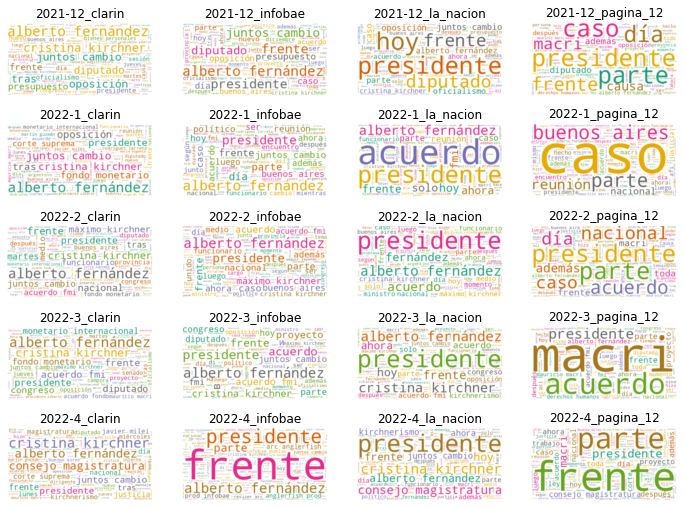

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def crear_wordclouds(df):
    wc = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)

    plt.rcParams['figure.figsize'] = [12,9]

    sources = complete_df.source.unique().tolist()

    index = 0

    width = 4
    height = int(np.round(len(complete_df.source.unique()) / width,0))

    for source in sources:
        index += 1
        bag = df.text[df.source == source].str.cat(sep=' ')
        wc.generate(bag)
        plt.subplot(height, width, index)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(source)

    plt.show()
    
crear_wordclouds(complete_df)

# Detección de Tópicos

In [12]:
import json, re
import pandas as pd 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer

In [13]:
tokenizer = ToktokTokenizer() 
corpus_df["Tokens"] = corpus_df.text.apply(tokenizer.tokenize)
corpus_df.head()

,text,Tokens
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,..."


In [14]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

corpus_df["Stems"] = corpus_df.Tokens.apply(stem_palabras)

corpus_df.head()

,text,Tokens,Stems
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro...","[juan, manzur, wad, pedr, cabecer, mes, ros, c..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci...","[vide, piñ, empujon, eleccion, president, juve..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ...","[derrot, grand, dificil, imagin, derrot, grand..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro...","[agustin, rossi, pas, peron, ex, ministr, defe..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,...","[debil, crec, ultim, esteb, bullrich, acto, pr..."


In [15]:
#!pip install pyLDAvis
#!python -m spacy download es_core_news_md

In [16]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data_words = corpus_df.Tokens.to_list()

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['juan_manzur', 'wado_pedro', 'cabecera', 'mesa', 'rosada', 'concejalas', 'edilas', 'juan_manzur', 'wado_pedro', 'sentaron', 'lunes', 'cabecera', 'mesa', 'trabajo', 'particular', 'jefe_gabinete', 'ministro', 'interior', 'recibieron', 'casa_rosada', 'representantes', 'red', 'federal', 'concejalas', 'federación', 'municipios', 'fam', 'encuentro', 'abordaron', 'temas', 'bien', 'diversos', 'nutrido_grupo', 'edilas', 'destacó', 'comunicado']


In [19]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [201]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_md') # , disable=['parser', 'ner']

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['VERB','NOUN']) # 'ADJ', 'ADV'

print(data_lemmatized[:1])

[['juan_manzur', 'mesa', 'sentar', 'lunes', 'mesa', 'recibir', 'representante', 'red', 'encuentro', 'abordar', 'tema', 'nutrido_grupo', 'destacar']]


In [164]:
data = []
for sentence in data_words_bigrams:
  data.append([word for word in sentence if len(word) > 3])

In [165]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [166]:
diccionario = Dictionary(data)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=25, no_above = 0.8)
print(f'Número de tokens limpiando palabras por frecuencia: {len(diccionario)}')

Número de tokens: 39460
Número de tokens limpiando palabras por frecuencia: 4030


In [167]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in data]

# Mostramos el BOW de una noticia
print(corpus[6])

[(4, 1), (21, 2), (47, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1)]


In [ ]:
#for k in range(5,25): # Train LDA on different values of k
#    print('Round: '+ str(k))
#    LDA = gensim.models.ldamulticore.LdaMulticore
#    ldamodel = LDA(corpus=corpus, num_topics=k, id2word = diccionario, passes=20, iterations=100,
#                   chunksize = 10000, eval_every = 10, random_state=20, workers=10)
#    ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
#    pprint(ldamodel.print_topics())

### Train models with "k" number of topics and evaluate coherence

In [44]:
from joblib import Parallel, delayed
import math

def sqrt_func(i, j):
    time.sleep(1)
    return math.sqrt(i**j)

def train_lda(k):
    print('Round: '+ str(k))
    LDA = gensim.models.ldamulticore.LdaMulticore
    ldamodel = LDA(corpus=corpus, num_topics=k, id2word = diccionario, passes=20, iterations=100,
                   chunksize = 10000, eval_every = 10, random_state=20, workers=10)
    ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
    pprint(ldamodel.print_topics())
    

Parallel(n_jobs=6)(delayed(train_lda)(k) for k in range(5,31))

Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30


[None, None, None, None, None, None]

In [48]:
import gensim
coherence = []
for k in range(5,31):
    LDA = gensim.models.ldamulticore.LdaMulticore
    ldamodel = LDA.load(f"ldamodel_for_{k}topics_Run_10")
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=data, dictionary=diccionario, coherence='c_v')
    coherence.append((k, 'default', 'default', cm.get_coherence()))

In [49]:
pd.DataFrame(coherence, columns=['LDA_Model','alpha','eta','coherence_score']).to_csv('coherence_matrix_10.csv', index=False)

In [50]:
mat = pd.read_csv('coherence_matrix_10.csv')
mat.reset_index(drop=True)
mat

,LDA_Model,alpha,eta,coherence_score
0,5,default,default,0.495489
1,6,default,default,0.510685
2,7,default,default,0.503259
3,8,default,default,0.502390
4,9,default,default,0.467203
5,10,default,default,0.488762
6,11,default,default,0.517845
7,12,default,default,0.515793
8,13,default,default,0.528730
9,14,default,default,0.530723


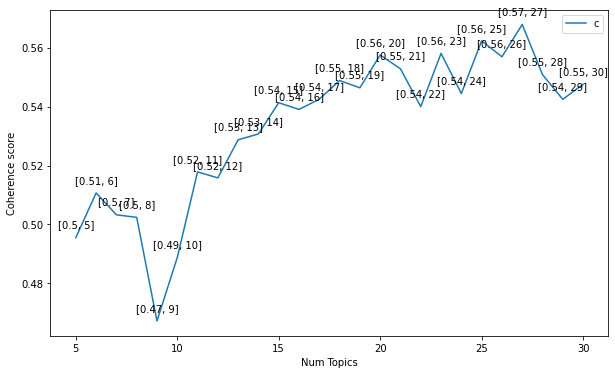

In [81]:
from matplotlib.pyplot import figure
# Show graph
x = range(5,31)
y = mat['coherence_score']
plt.plot(x,y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
for x, y in zip(x,y):
    label = [round(y,2),int(x)]
    plt.annotate(label, (x, y),
                 xycoords="data",
                 textcoords="offset points",
                 xytext=(0, 10), ha="center")
plt.rcParams["figure.figsize"] = (10,6)
plt.show() # Num Topics = 4 is having highest coherence score.

In [168]:
topics = 27
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=topics, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [169]:
topicos = lda.print_topics(num_words=5, num_topics=topics)
for topico in topicos:
    print(topico)

(0, '0.062*"proyecto" + 0.029*"diputado" + 0.023*"acuerdo" + 0.019*"debate" + 0.019*"oficialismo"')
(1, '0.043*"consejo_magistraturar" + 0.035*"juez" + 0.032*"corte" + 0.024*"justicia" + 0.023*"fallo"')
(2, '0.028*"persona" + 0.025*"caso" + 0.024*"salud" + 0.016*"vacuna" + 0.012*"millón"')
(3, '0.166*"cristina_kirchner" + 0.117*"vicepresidenta" + 0.060*"ataque" + 0.059*"mensaje" + 0.057*"presidente"')
(4, '0.053*"domingo" + 0.041*"lunes" + 0.038*"viernes" + 0.034*"jueves" + 0.030*"marzo"')
(5, '0.025*"país" + 0.018*"guerra" + 0.017*"defensa" + 0.016*"conflicto" + 0.016*"acción"')
(6, '0.030*"información" + 0.024*"dato" + 0.017*"persona" + 0.015*"investigación" + 0.011*"informe"')
(7, '0.044*"ciudad" + 0.036*"policía" + 0.025*"municipio" + 0.023*"seguridad" + 0.022*"zona"')
(8, '0.057*"diputado" + 0.052*"senador" + 0.050*"bloque" + 0.038*"presidente" + 0.030*"frente"')
(9, '0.062*"presidente" + 0.034*"reunión" + 0.028*"encuentro" + 0.016*"ministro" + 0.015*"mandatario"')
(10, '0.043*"gu

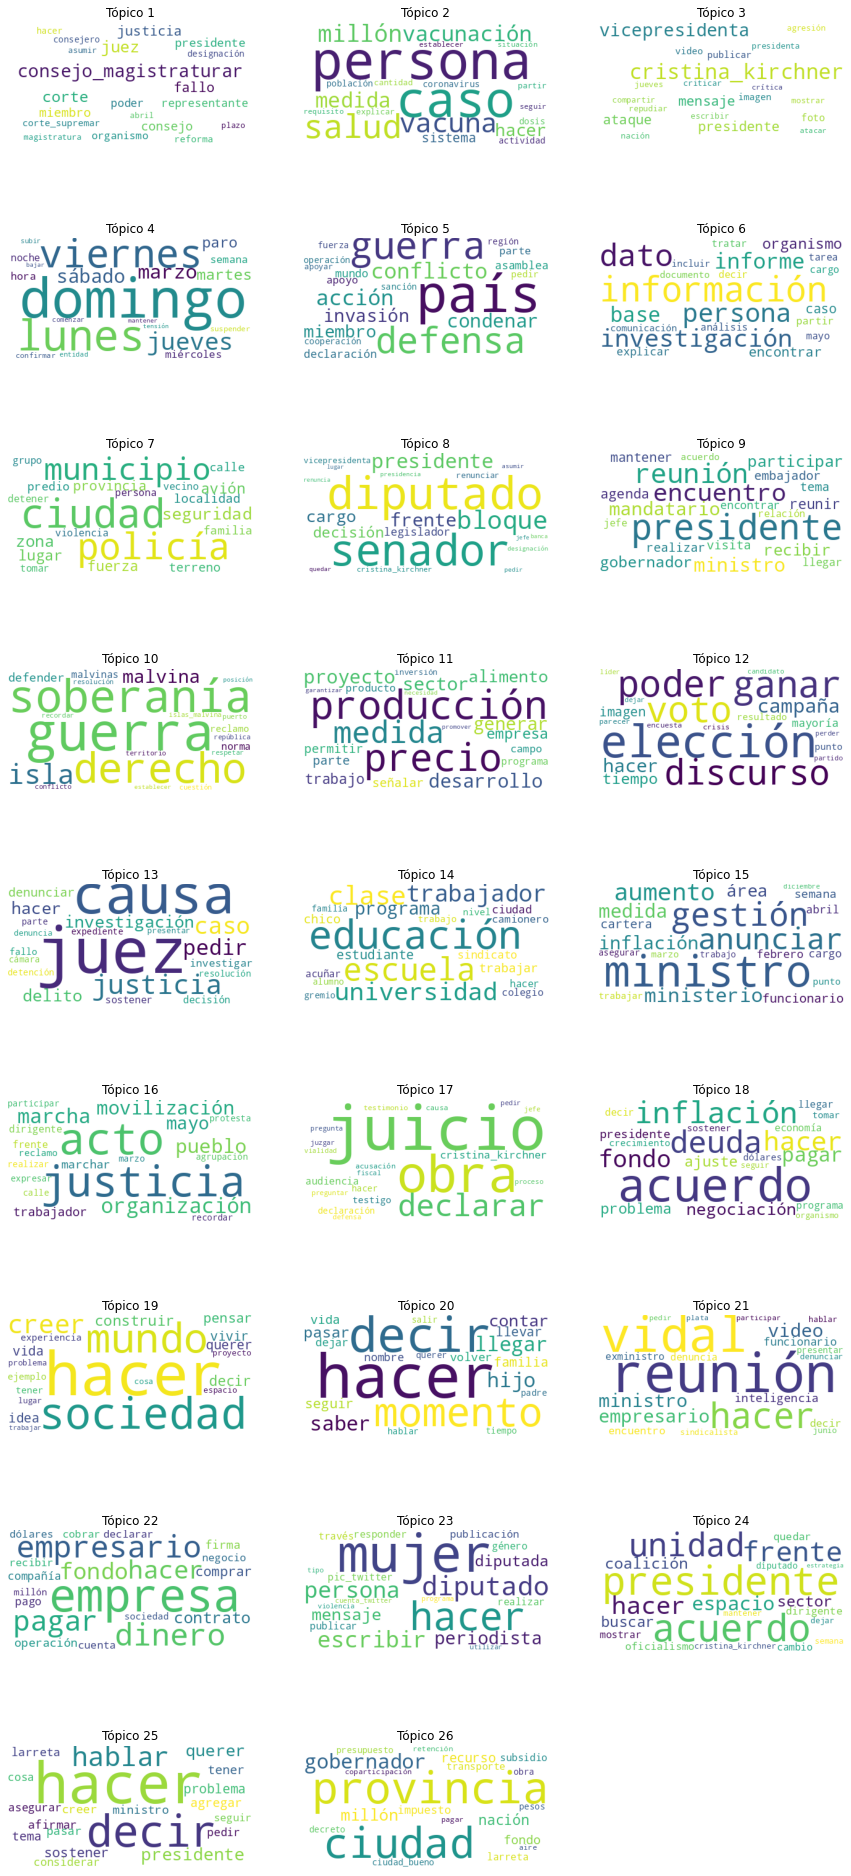

In [191]:
cant_topicos = topics
columnas = 3
if (cant_topicos % columnas) > 0:
    filas = int(cant_topicos/columnas) + 1
else:
    filas = int(cant_topicos/columnas)

for i in range(1, cant_topicos):
    plt.subplot(filas,columnas,i)
    plt.rcParams['figure.figsize'] = [15,25]
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
plt.show()

In [95]:
#Creating Topic Distance Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda, corpus, diccionario)

/home/nando/.work/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [96]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.138671  0.083423       1        1  12.295085
21     0.146221 -0.071766       2        1  10.273565
12     0.112967  0.034252       3        1   7.555397
26     0.042201  0.133565       4        1   6.092567
2      0.026586  0.107744       5        1   5.903196
18     0.055117 -0.094433       6        1   5.142373
15     0.171656 -0.125653       7        1   4.887299
10    -0.012491  0.020591       8        1   4.258436
22     0.142177 -0.128498       9        1   4.098209
11    -0.011112  0.077512      10        1   4.003436
20     0.115760  0.100854      11        1   3.493444
16     0.128232  0.162141      12        1   3.377415
1     -0.066446  0.094794      13        1   3.263139
14     0.108814  0.196452      14        1   3.098942
25     0.005799 -0.193637      15        1   2.839450
8     -0.010304  0.148768      16        1   2.353651
9      0.048515 -0.136246      17        1   2.194519
5     -0.023035 -0.076185      18        1   2.046925
13    -0.210613  0.000441      19        1   1.748803
0      0.013793 -0.065337      20        1   1.681177
17    -0.066149 -0.111664      21        1   1.629236
7     -0.105188 -0.111556      22        1   1.545504
23    -0.211270  0.010564      23        1   1.416663
19    -0.186840  0.092302      24        1   1.416060
24    -0.019027 -0.142811      25        1   1.371302
4     -0.092509 -0.067380      26        1   1.072780
6     -0.241524  0.061762      27        1   0.941427, topic_info=                   Term          Freq         Total Category  logprob  loglift
156          presidente  11987.000000  11987.000000  Default  30.0000  30.0000
564             acuerdo   9213.000000   9213.000000  Default  29.0000  29.0000
15             ministro   5882.000000   5882.000000  Default  28.0000  28.0000
187   alberto_fernández   6430.000000   6430.000000  Default  27.0000  27.0000
833             larreta   2431.000000   2431.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
743            posición    141.076721    915.453950  Topic27  -4.8301   2.7954
47              consejo    163.392163   1903.343189  Topic27  -4.6833   2.2103
544             militar    122.675691    734.358512  Topic27  -4.9699   2.8761
3083           exterior    107.305524    748.611995  Topic27  -5.1037   2.7230
1264          seguridad    107.154154   1952.603400  Topic27  -5.1052   1.7629

[1851 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
9258     24  0.990283      abastecimiento
2837      3  0.020695             abogado
2837      4  0.243905             abogado
2837     11  0.048781             abogado
2837     12  0.203994             abogado
...     ...       ...                 ...
552      13  0.995479    última_dictadura
4693      1  0.038171  últimas_elecciones
4693      9  0.104971  últimas_elecciones
4693     17  0.792052  últimas_elecciones
4693     22  0.057257  últimas_elecciones

[6448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 22, 13, 27, 3, 19, 16, 11, 23, 12, 21, 17, 2, 15, 26, 9, 10, 6, 14, 1, 18, 8, 24, 20, 25, 5, 7])

/home/nando/.work/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/nando/.work/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/nando/.work/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/nando/.work/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/nando/.work/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packagi

In [116]:
lda[corpus[0]]

[(3, 0.011824779),
 (4, 0.06817491),
 (12, 0.011260159),
 (21, 0.011609377),
 (25, 0.8241952)]

In [112]:
len(data[1])

38